# *INTRODUCTION*

**Machine Learning Path:**</br>
BERLIAN MUHAMMAD GALIN AL AWIENOOR (M360DKX4331)</br>
FAKHRUL MAULIDAN GUSTIANA (M360DKX4329) 

# ***MOBILENET V2***

MobileNetV2 is a Convolutional Neural Network (CNN) architecture specifically designed for image processing on mobile devices or Internet of Things (IoT) devices.

It combines several techniques to achieve good performance in image processing tasks. This architecture provides a balance between computational speed and image recognition quality, making it suitable for applications that require real-time image processing on devices with limited resources.

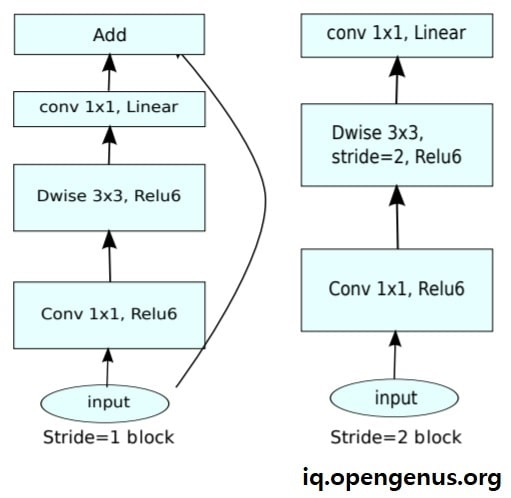

# ***Link Dataset & Repository***:

https://github.com/berlianm/Rubist-Application

# *IMPORTING*

In [ ]:
import os
import zipfile
import gdown
import glob

import random

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import tensorflow as tf

# *DATASET*

[DATASET](https://drive.google.com/drive/folders/1aDMo-ZzUSCMDFDD16CPP3Lofb64It41J?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import shutil

source_folder = '/content/drive/MyDrive/Garbage classification/Garbage classification'
destination_folder = '/content/data'

shutil.copytree(source_folder, destination_folder)

In [ ]:
dataset_paths = '/content/data'

img_list = glob.glob(os.path.join(dataset_paths , '*/*.jpg'))

print("Total Data:", len(img_list))

Total Data: 2527


# *Mobile Net*

In [ ]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


## *Fine Tuning*

In [ ]:
import tensorflow_hub as hub
do_fine_tuning = True #@param {type:"boolean"}

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

## *Image Data Generator*

Image Data Generator is a feature or function provided by deep learning libraries or frameworks, such as Keras and TensorFlow, that allows for automatic augmentation of image data. It allows to configure various transformations and augmentations that will be applied to the image while the data is being processed by the model.

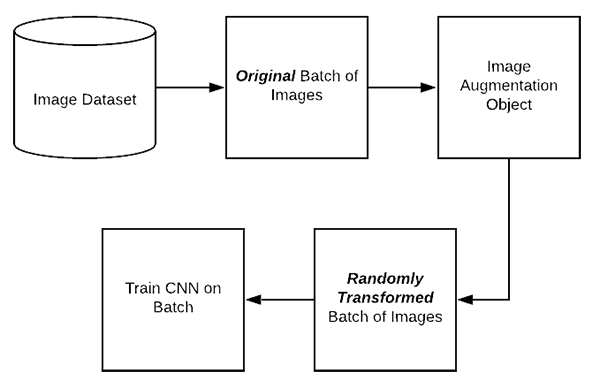

In [ ]:
train_dataset = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    fill_mode='nearest'
)

test_dataset = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

In [ ]:
train_generator = train_dataset.flow_from_directory(
    dataset_paths,
    target_size=IMAGE_SIZE,
    batch_size=25,
    class_mode='categorical',
    subset='training',
    seed=0
)

val_generator = test_dataset.flow_from_directory(
    dataset_paths,
    target_size=IMAGE_SIZE,
    batch_size=25,
    class_mode='categorical',
    subset='validation',
    seed=0
)

Found 2527 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)
print(len(labels))

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}
6


# *Modeling*

In [ ]:
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(labels), activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 2,587,462
Trainable params: 2,553,350
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
if do_fine_tuning:
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9)
    feature_extractor.trainable = True
else: 
    feature_extractor.trainable = False
    optimizer = "adam"

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('mobilenet_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
# fitting model
epochs = 75  # training epochs

history = model.fit(
    train_generator, 
    epochs=epochs, 
    steps_per_epoch=34, 
    validation_data=val_generator, 
    verbose=1, 
    validation_steps=5,
    callbacks=[mc]
)

Epoch 1/75
34/34 [==============================] - ETA: 0s - loss: 1.9121 - accuracy: 0.4565
Epoch 1: val_accuracy improved from -inf to 0.56000, saving model to mobilenet_model.h5
34/34 [==============================] - 119s 3s/step - loss: 1.9121 - accuracy: 0.4565 - val_loss: 1.5963 - val_accuracy: 0.5600
Epoch 2/75
34/34 [==============================] - ETA: 0s - loss: 1.3228 - accuracy: 0.7082
Epoch 2: val_accuracy improved from 0.56000 to 0.66400, saving model to mobilenet_model.h5
34/34 [==============================] - 106s 3s/step - loss: 1.3228 - accuracy: 0.7082 - val_loss: 1.3393 - val_accuracy: 0.6640
Epoch 3/75
34/34 [==============================] - ETA: 0s - loss: 1.2004 - accuracy: 0.7565
Epoch 3: val_accuracy improved from 0.66400 to 0.74400, saving model to mobilenet_model.h5
34/34 [==============================] - 108s 3s/step - loss: 1.2004 - accuracy: 0.7565 - val_loss: 1.1530 - val_accuracy: 0.7440
Epoch 4/75
34/34 [==============================] - ETA: 0

# *Saving Model*

In [ ]:
# save model
model_filename = 'mobilenet_model.h5'
model.save(model_filename)

# downloading
def download_file(file_path):
    from google.colab import files
    files.download(file_path)
download_file(model_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# *Model Evaluate*

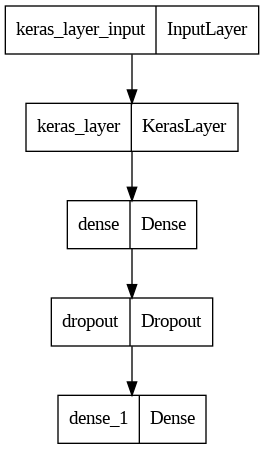

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model)

# *ACCURACY & LOSS*

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


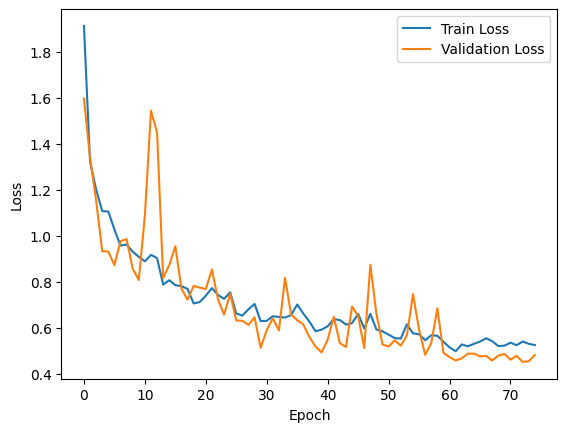

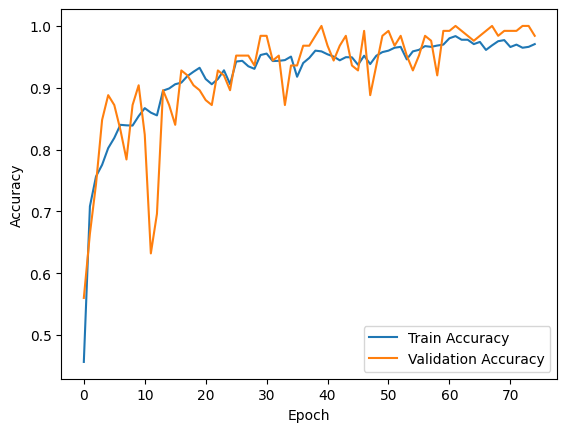

In [ ]:
print(history.history.keys())

# graph of accuracy and loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# *SCORE*

In [ ]:
score = model.evaluate(train_generator, return_dict=True, verbose=0)
print("TRAIN SCORE")
print(score)

TRAIN SCORE
{'loss': 0.5050315260887146, 'accuracy': 0.9734863638877869}
